# Preparação dos dados
Importando as bibliotecas que serão usadas nesse exemplo.

In [348]:
import numpy as np
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.regression import LinearRegressionWithSGD
from pyspark.mllib.evaluation import RegressionMetrics

Caminho para os dados do exemplo.

In [317]:
path = "/Users/leandro/Dropbox/Backup/Cursos/DM/AD2-2015.2/data/TV_noheader.csv"

Lendo os dados para ```raw_data```.

In [318]:
raw_data = sc.textFile(path)

Separando os atributos por vírgula.

In [347]:
records = raw_data.map(lambda x: x.split(","))
records.take(5)

[[u'230.1', u'22.1'],
 [u'44.5', u'10.4'],
 [u'17.2', u'9.3'],
 [u'151.5', u'18.5'],
 [u'180.8', u'12.9']]

Transformando os dados no formato LabeledPoint do Spark MLLib.

In [316]:
def parsePoint(record):
    values = [float(x) for x in record]
    return LabeledPoint(values[1],np.atleast_1d(values[0]))

In [320]:
parsed_data = records.map(parsePoint)
parsed_data.take(5)

[LabeledPoint(22.1, [230.1]),
 LabeledPoint(10.4, [44.5]),
 LabeledPoint(9.3, [17.2]),
 LabeledPoint(18.5, [151.5]),
 LabeledPoint(12.9, [180.8])]

# Treinando e avaliando o modelo.
Abaixo treinamos um modelo de regressão linear usando os parâmetros indicados. Em seguida, atribuímos a variável ```valuesAndPreds``` pares (valore previso,valor real).


In [321]:
linear_model = LinearRegressionWithSGD.train(parsed_data,iterations=50,
step=0.01,intercept=True)
valuesAndPreds=parsed_data.map(lambda p: (float(linear_model.predict(p.features)),p.label))

O objeto ```metrics``` abaixo permite chamar várias funções de avaliação para o modelo de regressão.

In [322]:
metrics = RegressionMetrics(valuesAndPreds)

In [323]:
print("MSE = %s" % metrics.meanSquaredError)
print("RMSE = %s" % metrics.rootMeanSquaredError)

# R-squared
print("R-squared = %s" % metrics.r2)

# Mean absolute error
print("MAE = %s" % metrics.meanAbsoluteError)

MSE = 1.64212205661e+183
RMSE = 4.05231052192e+91
R-squared = -6.06268032278e+181
MAE = 3.50173413823e+91


# Partição treino/teste

In [324]:
data_with_idx = parsed_data.zipWithIndex().map(lambda (k, v): (v, k))
test = data_with_idx.sample(False, 0.2, 42)
train = data_with_idx.subtractByKey(test)

Agora retiramos os índices e recuperamos somente as instâncias de cada partição.

In [325]:
train_data = train.map(lambda (idx, p): p)
test_data = test.map(lambda (idx, p) : p)
train_size = train_data.count()
test_size = test_data.count()
print "Tamanho dos dados de treino: %d" % train_size
print "Tamanho dos dados de teste: %d" % test_size
print "Tamanho total: %d " % num_data
print "Tamanho treino + tamanho teste : %d" % (train_size + test_size)

Tamanho dos dados de treino: 160
Tamanho dos dados de teste: 40
Tamanho total: 200 
Tamanho treino + tamanho teste : 200


Função para treinar um modelo nos dados de treino, avaliar no teste e retornar uma métrica de avaliação.

In [331]:
def evaluate(train, test, iterations, step, regParam, regType,intercept):
    model = LinearRegressionWithSGD.train(train, iterations, step,
    regParam=regParam, regType=regType, intercept=intercept)
    tp = test.map(lambda p: (float(model.predict(p.features)),p.label))
    result = RegressionMetrics(tp)
    rmse = result.rootMeanSquaredError
    return rmse

# Variando o número de iterações

In [333]:
params = [1,5,10,20,50,100]
results = [evaluate(train_data, test_data, param, .01, 0.0, 'l2',True) for param in params]
print params
print results

[1, 5, 10, 20, 50, 100]
[3647.2385290766065, 2610754821711.72, 3.4454392953529866e+22, 2.135136480015719e+41, 2.03633706153293e+92, inf]


Populating the interactive namespace from numpy and matplotlib


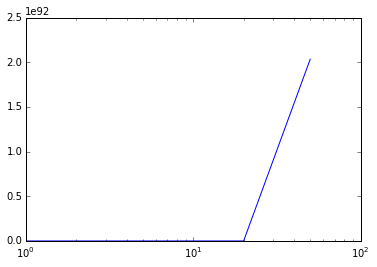

In [335]:
%pylab inline
plot(params, results)
fig = matplotlib.pyplot.gcf()
pyplot.xscale('log')

# Variando o step size do SGD

In [339]:
params = [0.00001,0.0001,0.001,0.01, 0.025, 0.05, 0.1, 1.0]
results = [evaluate(train_data, test_data, 10, param, 0.0, 'l2',
True) for param in params]
print params
print results

[1e-05, 0.0001, 0.001, 0.01, 0.025, 0.05, 0.1, 1.0]
[5.202386143732566, 4.226335186266995, 1697904610642.6682, 3.4454392953529866e+22, 3.438046729039842e+26, 3.573928929958777e+29, 3.687304009689063e+32, 3.7123031397359215e+42]


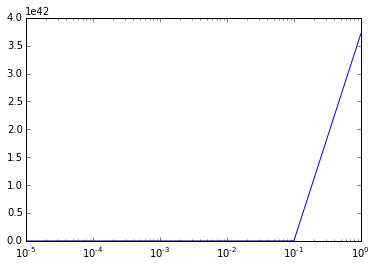

In [340]:
plot(params, results)
fig = matplotlib.pyplot.gcf()
pyplot.xscale('log')

# Variando o parâmetro de regularização do LASSO

[0.0, 0.01, 0.1, 1.0, 10.0, 100.0]
[4.226335186266995, 4.226346810002347, 4.226451452577864, 4.227500744320124, 4.238279463175514, 4.374316498789672]


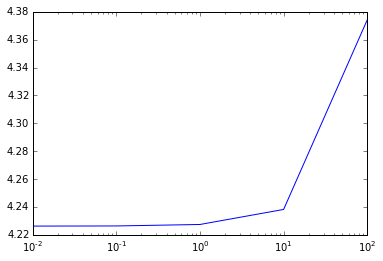

In [346]:
params = [0.0, 0.01, 0.1, 1.0, 10.0, 100.0]
results = [evaluate(train_data, test_data, 10, 0.0001, param, 'l1',
True) for param in params]
print params
print results
plot(params, results)
fig = matplotlib.pyplot.gcf()
pyplot.xscale('log')